In [1]:
#from v4_RGF_BBG.py import test_Gk_single
from FastRGF.solveRGF import MOMfastrecDOSfull
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# from scipy.linalg import norm
from scipy.integrate import simpson, quad
from functools import partial
import mpmath

%load_ext autoreload
%autoreload 2

### Import of functions from file without dask

In [52]:
epsA1 = 0 
deltaprime = 0.022
epsA2 = deltaprime
epsB1 = deltaprime
epsB2 = 0
gamma0 = 3.16
gamma1 = 0.381
gamma3 = 0.38
gamma4 = 0.14



def ret_H0(kx):
	Tx = np.zeros((8,8),dtype=np.cdouble)
	Tx[0,5] = -gamma3
	Tx[0,6] = -gamma0
	Tx[0,7] = gamma4
	Tx[2,5] = gamma4
	Tx[3,5] = -gamma0
	Tx = Tx * np.exp(-1j*kx)
	#P = Tx + Tx.conj().T

	#Horrible code ahead : please don't judge

	M = np.zeros((8,8),dtype=np.cdouble)
	M[0,0] = epsB2
	M[0,1] = -gamma3
	M[0,2] = -gamma0
	M[0,3] = gamma1
	M[1,1] = epsA1
	M[1,2] = gamma4
	M[1,3] = -gamma0
	M[1,4] = -gamma3
	M[1,6] = gamma4
	M[1,7] = -gamma0
	M[2,2] = epsA2
	M[2,3] = gamma1
	M[2,4] = -gamma0
	M[3,3] = epsB1
	M[3,4] = gamma4
	M[4,4] = epsB2
	M[4,5] = -gamma3
	M[4,6] = -gamma0
	M[4,7] = gamma4
	M[5,5] = epsA1
	M[5,6] = gamma4
	M[5,7] = -gamma0
	M[6,6] = epsA2
	M[6,7] = gamma1
	M[7,7] = epsB1
	M = M + Tx
	M = M + M.conj().T - np.diag(np.diag(M))

	return M 


def ret_Ty(kx):
	# non-hermitian : only couples along -ve y direction
	Ty = np.zeros((8,8),dtype = np.cdouble)
	Ty[0,2] = -gamma0
	Ty[0,3] = gamma4
	Ty[0,5] = -gamma3 * np.exp(-1j*kx, dtype = np.cdouble)
	Ty[1,2] = gamma4
	Ty[1,3] = -gamma0
	Ty[1,4] = -gamma3
	Ty[6,4] = -gamma0
	Ty[6,5] = gamma4
	Ty[7,4] = gamma4
	Ty[7,5] = -gamma0

	return Ty


def generate_grid_with_peaks(a, b, peaks, peak_spacing=0.01, num_pp = 200, num_uniform=1000):
    # Sort the peaks list
    assert a < b , "a should be less than b" 
    peaks = sorted(peaks)
    
    # Generate grid around peaks
    peak_grid = np.concatenate([np.linspace(max(a, peak - peak_spacing), min(b, peak + peak_spacing), num = num_pp, dtype=np.double)
                                for peak in peaks])

    # Generate uniform grid for the remaining region
    # uniform_grid = np.linspace(max(a, min(peaks, default=a) + peak_spacing),
    #                            min(b, max(peaks, default=b) - peak_spacing), num=int((b - a) / uniform_spacing))
    uniform_grid = np.linspace(a,b,num=num_uniform,dtype=np.double)

    # Concatenate the peak and uniform grids
    grid = np.sort(np.concatenate([peak_grid, uniform_grid]))

    return grid


def test_Ginfkx():
	# omega = 1 - 1e-2
	omega = 2e-3 
	# omega = 0.000444967
	# omega = 0.000740532
	# omega = 2e-2
	omegavals = (omega,)
	# kxvals = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
	kxvals = np.linspace(-0.2,0.2,1000,dtype=np.double)
	# delta = min(1e-4,0.01*omega)
	# delta = 1e-4 if omega>1e-3 else 1e-6
	delta = 1e-6
	# delta = 0.01*omega
	RECURSIONS = 30
	dimH = 8
	num_pp = 2000
	start_time = time.perf_counter()
	kDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
					for omega in omegavals for kx in kxvals],dtype=np.longdouble).reshape((len(omegavals),len(kxvals),dimH,dimH))
	# peaks = find_peaks(kDOS[0,:,0,0],prominence=0.01*np.max(kDOS[0,:,0,0]))[0]
	peaks = find_peaks(kDOS[0,:,0,0],prominence=0.1)[0]
	print(f'Peaks found on sparse grid : {len(peaks)}')
	peakvals = [kxvals[peak] for peak in peaks]
	print("creating fine grid")
	adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=1000,num_pp=num_pp)
	fine_integrand = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0] for kx in adaptive_kxgrid],dtype=np.double)

	print('finding additional peaks')
	# new_peaks = find_peaks(fine_integrand,prominence=0.01*np.max(fine_integrand))[0]
	new_peaks = find_peaks(fine_integrand,prominence=0.1)[0]
	new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
	new_peakvals = sorted(new_peakvals)

	fig, ax = plt.subplots(1)
	ax.plot(kxvals, kDOS[0,:,0,0])
	ax.set_xlabel(r'$k_x$')
	ax.set_title(f'$\\omega$ = {omega:.3}, \\delta = {delta:.6}, RECURSIONS = {RECURSIONS}')
	# ax.vlines(kxvals[peaks], ls = '--', c = 'grey')
	for peak in new_peakvals:
		ax.axvline(peak,ls='--',c='gray')

	# ax.legend()
	# print('Started quad integrate without peaks')
	# start_time = time.perf_counter()
	# intval = quad(lambda kx : MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta,)[0,0], 
	# 					-np.pi,np.pi)[0]
	# elapsed = time.perf_counter() - start_time
	# print(f'Finished quad integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# print(f'intval = {intval:.5}')

	print(f'Total number of peaks found = {len(new_peakvals)}')

	# print('Started quad integrate WITH peaks')
	# start_time = time.perf_counter()
	# call_int = lambda kx : MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0]

	# start,stop = -np.pi,np.pi
	# ranges = []
	# eta = 0.5*delta
	# # eta = 1e-3
	# current = start
	# for peak in new_peakvals:
	# 	ranges += [(current, peak-eta)]
	# 	current = peak+eta
	# ranges += [(current, stop)]		
	# intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
	# for word in list(zip(ranges,intlist)):
	# 	print(word)
	# intval = np.sum(intlist)

	# # intval = quad(call_int, -np.pi,np.pi, points = [kxvals[peak] for peak in peaks])[0]
	# elapsed = time.perf_counter() - start_time
	# print(f'Finished quad integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# print(f'intval = {intval:.5}')

	# print('STARTED SIMPSON INTEGRATION')
	# start_time = time.perf_counter()
	# simpson_intval = simpson(fine_integrand,adaptive_kxgrid)
	# elapsed = time.perf_counter() - start_time
	# print(f'Finished simpson integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# print(f'intval = {simpson_intval:.8}')



	# for num_pp in [2000]: #checking convergence
	# 	print('Started simpson integrate WITH peaks')
	# 	peak_spacing = 0.01
	# 	print(f'num_pp = {num_pp}, peak_spacing = {peak_spacing:.4}')
	# 	start_time = time.perf_counter()
	# 	adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,new_peakvals,peak_spacing=0.1,num_uniform=10000,num_pp=num_pp)
	# 	fine_integrand = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0] for kx in adaptive_kxgrid],dtype=np.double)
	# 	simpson_intval = simpson(fine_integrand,adaptive_kxgrid)
	# 	elapsed = time.perf_counter() - start_time
	# 	print(f'Finished simpson integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# 	print(f'intval = {simpson_intval:.8}')
	# print(type(fine_integrand[0]))
	ax.plot(adaptive_kxgrid,fine_integrand,'.',c='red')
	plt.show()
	print(adaptive_kxgrid[fine_integrand<0])
    
    
def helper_LDOS_mp(omega):
    RECURSIONS = 20
    delta = 1e-4 #if omega>1e-3 else 1e-6
    num_pp = 1000
    call_int = lambda kx : MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[1,1]
    
    kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
    # sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
    # 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
    sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
    peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
    peakvals = [kxgrid[peak] for peak in peaks] #peakvals
    peakvals = sorted(peakvals)

    if len(peakvals) > 20:
        return float('NaN')

    adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
    fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
    new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
    new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
    new_peakvals = sorted(new_peakvals)

    if len(new_peakvals) > 25:
        return float('NaN')

    start,stop = -np.pi,np.pi
    ranges = []
    # eta = 0.5*delta
    eta = 0.5*delta
    current = start
    for peak in new_peakvals:
        ranges += [(current, peak-eta)]
        current = peak+eta
    ranges += [(current, stop)]    
    intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
    LDOS = np.sum(intlist)
    print('done', omega)
    return LDOS


def helper_LDOS_mpmath_version(omega):
    RECURSIONS = 20
    delta = 1e-4 #if omega>1e-3 else 1e-6
    num_pp = 1000
    call_int = lambda kx : MOMfastrecDOSfull(omega,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
    kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
    # sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
    # 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
    sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
    peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
    peakvals = [kxgrid[peak] for peak in peaks] #peakvals
    peakvals = sorted(peakvals)

    if len(peakvals) > 20:
        return float('NaN')

    adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
    fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
    new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
    new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
    new_peakvals = sorted(new_peakvals)

    if len(new_peakvals) > 25:
        return float('NaN')

    start,stop = -np.pi,np.pi
    ranges = []
    # eta = 0.5*delta
    eta = 0.5*delta
    current = start
    for peak in new_peakvals:
        ranges += [(current, peak-eta)]
        current = peak+eta
    ranges += [(current, stop)]    
    intlist = [float(mpmath.quad(call_int,[window[0],window[1]])) for window in ranges]
    LDOS = np.sum(intlist)
    print('done mpmath', omega)
    return LDOS


def test_LDOS_mp():
    '''
    Use scipy.quad for this
    '''
    #RECURSIONS = 25
    #delta = 1e-3
    omegavals = np.logspace(np.log10(1e-6), np.log10(1.5e0), num = 100)

    
    
    LDOS = [helper_LDOS_mp(wi) for wi in omegavals]
    #print(LDOS)
    
    #savedict = {'omegavals' : omegavals,
    #			'LDOS' : LDOS,
    #			'INFO' : '[0,0] site of -1/pi Im G, delta = 1e-4 if omega>1e-3 else 1e-6, RECURSIONS = 25'
    #			}
    fig,ax = plt.subplots(1)
    ax.plot(omegavals, LDOS, '.-', label = 'quad LDOS')
    ax.axvline(1., ls='--', c='grey')
    ax.set_xlabel('omega')
    # ax.set_title(f'Bilayer Graphene LDOS A site with $\\delta = $ {delta:.6}')
    plt.show()

### Test of DOS run on small scale set of omega

done 1e-06
done 7.196856730011514e-06
done 5.1794746792312125e-05
done 0.0003727593720314938
done 0.0026826957952797246
done 0.019306977288832496
done 0.1389495494373136
done 1.0


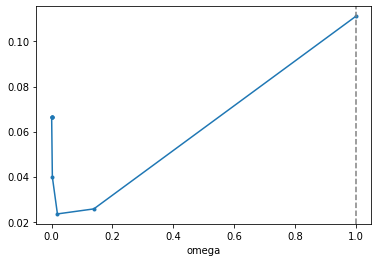

In [42]:
test_LDOS_mp()

done 1e-06
done 1.1544756045607413e-06
done 1.3328139215258865e-06
done 1.5387011578205702e-06
done 1.7763929494132119e-06
done 2.0508023242112562e-06
done 2.367601253078359e-06
done 2.733337888006407e-06
done 3.1555719107249703e-06
done 3.643030789369104e-06
done 4.205790172990282e-06
done 4.8554821526185805e-06
done 5.605535693578215e-06
done 6.471454208730524e-06
done 7.47113601001131e-06
done 8.625244261913331e-06
done 9.95763408375644e-06
done 1.1495845628839358e-05
done 1.3271673332291247e-05
done 1.5321823093829606e-05
done 1.7688670979221627e-05
done 2.042113912261293e-05
done 2.357570693439752e-05
done 2.7217578516035438e-05
done 3.14220304119794e-05
done 3.627596755639591e-05
done 4.187971957569592e-05
done 4.8349114575985866e-05
done 5.581787328008772e-05
done 6.444037300032412e-05
done 7.439483857766871e-05
done 8.588702624315285e-05
done 9.915447654598794e-05
done 0.00011447142425533328
done 0.00013215446672210486
done 0.00015256910786440423
done 0.00017613731303905086
don

<ipython-input-43-7e15895ed468>:230: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]


done 0.020162689088087615
done 0.02327733267454021
done 0.026873112712001254
done 0.03102435304461659
done 0.03581685873728954
done 0.041349689644199016
done 0.047737207950385586
done 0.05511144200856322
done 0.06362481533105013
done 0.07345329714437963
done 0.08480003962773727
done 0.09789957701600682
done 0.1130226733617951
done 0.1304819191584296
done 0.15063819250467347
done 0.17390811836177025
done 0.20077268008372526
done 0.23178716121893903
done 0.26759262307765214
done 0.308929155303567
done 0.35665117333552393
done 0.4117450789538268
done 0.4753496489501284
done 0.5487795733494356
done 0.633552629713174
done 0.7314210552091641
done 0.8444077649010534
done 0.974848164879928
done 1.1254384245046818
done 1.299291205525931
done 1.5


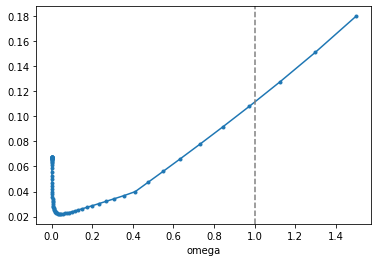

In [44]:
test_LDOS_mp()

In [10]:
kx =  0.00073387
omega = 2e-3
RECURSIONS = 30
delta = 1e-6
DOSkx = MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0]
print(DOSkx)

[[ 0.86780996+0.06587328j -1.1453415 -0.10994893j  0.16540162+0.00246276j
  -0.04971415+0.00115906j -0.86895758-0.06548117j  1.23118694+0.11439097j
  -0.17522283-0.00295996j  0.04863127-0.00126631j]
 [ 0.53615283-0.04608413j  5.19684303+0.00861432j  0.62624625-0.01493847j
   0.24742468-0.01992061j -0.49705442+0.04334108j -5.07715748-0.0104518j
  -0.64041716+0.01515681j -0.24952254+0.02047689j]
 [ 0.09093957-0.02007246j  0.99766211+0.02027283j  0.01531817+0.00179857j
  -0.0169172 -0.00350442j  0.22457703+0.01960119j -0.97502372-0.02091434j
  -0.01984496-0.00173088j -0.02060373+0.00357275j]
 [ 0.00588436+0.00474668j  0.09276541+0.01844144j -0.02232614+0.00179283j
  -0.01661581+0.00038618j  0.00591027-0.00466288j  0.22185142-0.01801992j
  -0.01565491-0.0018411j   0.0133737 -0.00039801j]
 [-0.86309603-0.06531026j  1.16436311+0.11204648j  0.14971212-0.00221631j
   0.06138381-0.00114935j  0.86935753+0.06492401j -1.21155696-0.11642995j
   0.17250193+0.00270677j -0.04708817+0.00125561j]
 [-0.4

### Test mpmath quadrature

In [53]:
omegavals = np.logspace(np.log10(1e-6), np.log10(0.25e0), num = 10)
LDOS_mpmath = [helper_LDOS_mpmath_version(wi) for wi in omegavals]
LDOS = [helper_LDOS_mp(wi) for wi in omegavals]
print('scipy', list(LDOS))
print('mpmath', list(LDOS_mpmath))

done mpmath 1e-06
done mpmath 3.9789740984925685e-06
done mpmath 1.5832234876474746e-05
done mpmath 6.299605249474357e-05
done mpmath 0.00025065966118386306
done mpmath 0.000997368299387514
done mpmath 0.003968502629920496
done mpmath 0.01579056917425329
done mpmath 0.06283026574480902
done mpmath 0.25
done 1e-06
done 3.9789740984925685e-06
done 1.5832234876474746e-05
done 6.299605249474357e-05
done 0.00025065966118386306
done 0.000997368299387514
done 0.003968502629920496
done 0.01579056917425329


<ipython-input-52-f64f1eed3a43>:230: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]


done 0.06283026574480902
done 0.25
scipy [0.10126218221023715, 0.10083875986750816, 0.09916467956052166, 0.09324246305028742, 0.0839835706100283, 0.05841263631256928, 0.032606221723735646, 0.02418670725349543, 0.02247634951652512, 0.03143527163361074]
mpmath [0.1012621821654499, 0.10083875987001158, 0.09916469217918658, 0.0932424630358833, 0.08398357062668439, 0.058412636586427674, 0.03260622490061041, 0.024186827725321516, 0.022759739103880208, 0.031606085110435195]


### Analysis of singular frequency values found earlier

In [56]:
omega_test = 0.06283026574480902
RECURSIONS = 20
delta = 1e-4 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
LDOS = np.sum(intlist)
#print('done mpmath', omega)

new_peakvals= [-0.13653505684756423, -0.07952027319016768, 0.07952027319016812, 0.13653505684756423]
ranges= [(-3.141592653589793, -0.13658505684756422), (-0.13648505684756423, -0.07957027319016767), (-0.07947027319016768, 0.07947027319016813), (0.07957027319016811, 0.13648505684756423), (0.13658505684756422, 3.141592653589793)]


<ipython-input-56-eef62b06b81a>:35: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]


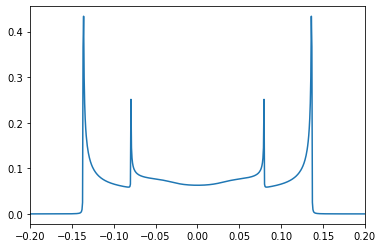

In [58]:
fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

new_peakvals= [-0.28100271162411816, -0.22039781993377303, 0.22039781993377303, 0.2810027116241186]
ranges= [(-3.141592653589793, -0.28105271162411816), (-0.28095271162411817, -0.22044781993377302), (-0.22034781993377303, 0.22034781993377303), (0.22044781993377302, 0.2809527116241186), (0.2810527116241186, 3.141592653589793)]


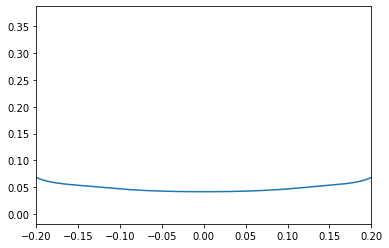

In [59]:
omega_test = 0.25
RECURSIONS = 20
delta = 1e-4 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
#intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
#LDOS = np.sum(intlist)
#print('done mpmath', omega)

fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

new_peakvals= [-0.08732110987668587, -0.034677215033019106, 0.03467721503301955, 0.08732110987668631]
ranges= [(-3.141592653589793, -0.08737110987668587), (-0.08727110987668588, -0.03472721503301911), (-0.034627215033019104, 0.03462721503301955), (0.03472721503301955, 0.08727110987668632), (0.08737110987668631, 3.141592653589793)]


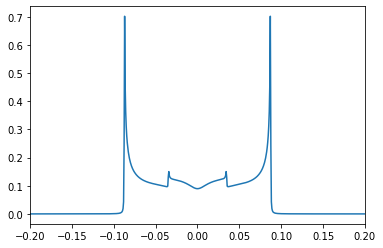

In [60]:
omega_test = 0.020162689088087615
RECURSIONS = 20
delta = 1e-4 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
#intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
#LDOS = np.sum(intlist)
#print('done mpmath', omega)

fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

new_peakvals= [-0.06864984899122098, -0.019355821940262544, 0.019355821940262988, 0.06864984899122142]
ranges= [(-3.141592653589793, -0.06865484899122098), (-0.06864484899122097, -0.019360821940262545), (-0.019350821940262542, 0.019350821940262986), (0.01936082194026299, 0.06864484899122142), (0.06865484899122143, 3.141592653589793)]


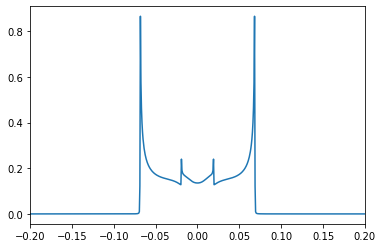

In [61]:
omega_test = 0.01
RECURSIONS = 25
delta = 1e-5 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
#intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
#LDOS = np.sum(intlist)
#print('done mpmath', omega)

fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

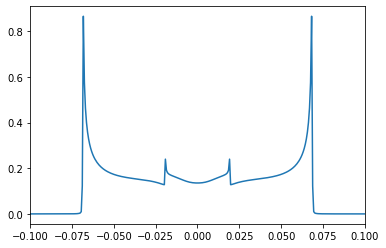

In [62]:
fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.1, 0.1])
plt.show()

new_peakvals= [-0.03944400572359762, -0.0030779664100966993, 0.0030779664100971434, 0.03944400572359806]
ranges= [(-3.141592653589793, -0.039449005723597615), (-0.03943900572359762, -0.003082966410096699), (-0.0030729664100966995, 0.0030729664100971436), (0.0030829664100971432, 0.03943900572359806), (0.03944900572359806, 3.141592653589793)]


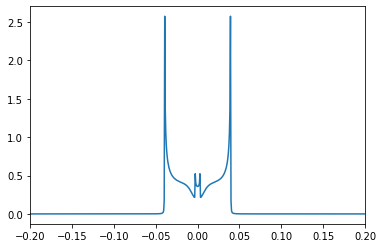

In [63]:
omega_test = 0.002
RECURSIONS = 25
delta = 1e-5 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
#intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
#LDOS = np.sum(intlist)
#print('done mpmath', omega)

fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

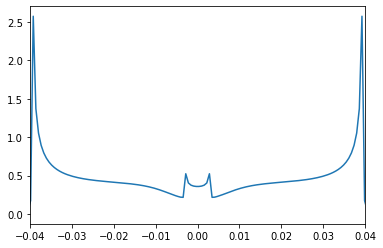

In [64]:
fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.04, 0.04])
plt.show()

C:\Users\dorie\DataDisc\research\Active_projects\NRG_bilayer_graphene\RKKYTightBinding-main\python_files\BLG\..\FastRGF\solveRGF.py:64: RuntimeWarning: overflow encountered in matmul
  tprod = tprod@tnb
C:\Users\dorie\DataDisc\research\Active_projects\NRG_bilayer_graphene\RKKYTightBinding-main\python_files\BLG\..\FastRGF\solveRGF.py:64: RuntimeWarning: invalid value encountered in matmul
  tprod = tprod@tnb


FOUND overflow in tprod
[[  0. +0.j   0. +0.j  inf+nanj  inf+nanj  inf+nanj  nan-infj   0. +0.j
    0. +0.j]
 [  0. +0.j   0. +0.j  nan-infj  nan-infj  nan-infj -inf+nanj   0. +0.j
    0. +0.j]
 [  0. +0.j   0. +0.j -inf+nanj -inf+nanj -inf+nanj  nan+infj   0. +0.j
    0. +0.j]
 [  0. +0.j   0. +0.j  inf+nanj  inf+nanj  inf+nanj  nan-infj   0. +0.j
    0. +0.j]
 [  0. +0.j   0. +0.j -inf+nanj -inf+nanj -inf+nanj  nan+infj   0. +0.j
    0. +0.j]
 [  0. +0.j   0. +0.j  nan+infj  nan+infj  nan+infj  inf+nanj   0. +0.j
    0. +0.j]
 [  0. +0.j   0. +0.j  inf+nanj  inf+nanj  inf+nanj  nan-infj   0. +0.j
    0. +0.j]
 [  0. +0.j   0. +0.j -inf+nanj -inf+nanj -inf+nanj  nan+infj   0. +0.j
    0. +0.j]]
FOUND overflow in tprod
[[  0. +0.j   0. +0.j  nan-infj  nan+infj  nan+infj  nan-infj   0. +0.j
    0. +0.j]
 [  0. +0.j   0. +0.j -inf+nanj  inf+nanj  inf+nanj -inf+nanj   0. +0.j
    0. +0.j]
 [  0. +0.j   0. +0.j  nan+infj  nan-infj  nan-infj  nan+infj   0. +0.j
    0. +0.j]
 [  0. +0.j   0.

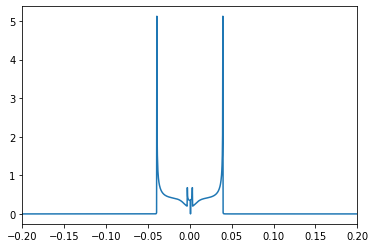

In [65]:
omega_test = 0.002
RECURSIONS = 25
delta = 1e-6 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,20000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
#intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
#LDOS = np.sum(intlist)
#print('done mpmath', omega)

fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

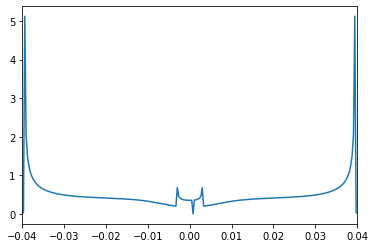

In [66]:
fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.04, 0.04])
plt.show()

new_peakvals= [-0.03945898928054463, -0.0030747523441133646, 0.0030747523441129188, 0.03945898928054418]
ranges= [(-3.141592653589793, -0.039462489280544626), (-0.03945548928054463, -0.0030782523441133646), (-0.0030712523441133645, 0.0030712523441129187), (0.003078252344112919, 0.03945548928054418), (0.039462489280544175, 3.141592653589793)]


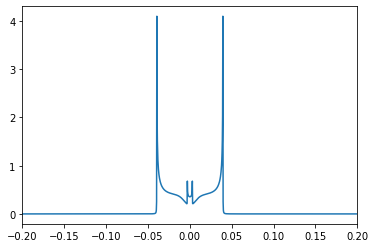

In [3]:
omega_test = 0.002
RECURSIONS = 25
delta = 7e-6 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,20000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
#intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
#LDOS = np.sum(intlist)
#print('done mpmath', omega)

fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

In [6]:
omega_test = 0.002
RECURSIONS = 25
delta = 7e-6 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,20000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
#intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
#LDOS = np.sum(intlist)
#print('done mpmath', omega)

fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

KeyboardInterrupt: 

### Search for how overflows modify result

new_peakvals= [-0.03948404576363766, -0.0030881997560690223, -0.0006857973536666204, 0.0007756641077948413, 0.0030881997560694655, 0.039484045763638106]
ranges= [(-3.141592653589793, -0.03948514576363766), (-0.039482945763637665, -0.0030892997560690223), (-0.0030870997560690223, -0.0006868973536666204), (-0.0006846973536666205, 0.0007745641077948414), (0.0007767641077948413, 0.0030870997560694655), (0.0030892997560694655, 0.03948294576363811), (0.0394851457636381, 3.141592653589793)]


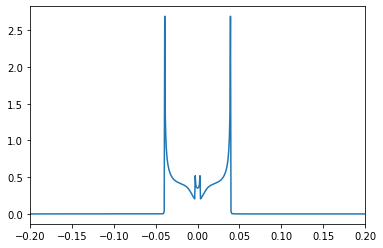

In [45]:
omega_test = 0.002
RECURSIONS = 20
delta = 2.2e-6 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
#intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
#LDOS = np.sum(intlist)
#print('done mpmath', omega)

fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

new_peakvals= [-0.04242575240771164, -0.011722906162138898, -0.007191067561304162, -0.004926779373228151, 1.4077763794886206e-06, 0.004926779373228595, 0.007188594963566677, 0.0117229061621389, 0.04242575240771208]
ranges= [(-3.141592653589793, -0.04242625240771164), (-0.04242525240771164, -0.011723406162138898), (-0.011722406162138897, -0.007191567561304161), (-0.007190567561304162, -0.00492727937322815), (-0.004926279373228151, 9.077763794886206e-07), (1.9077763794886204e-06, 0.004926279373228595), (0.004927279373228594, 0.007188094963566678), (0.007189094963566677, 0.011722406162138899), (0.0117234061621389, 0.04242525240771208), (0.042426252407712084, 3.141592653589793)]


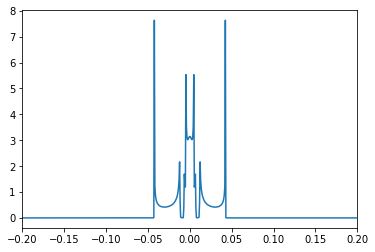

In [72]:
omega_test = 0.0001
RECURSIONS = 30
delta = 1e-6 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
#intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
#LDOS = np.sum(intlist)
#print('done mpmath', omega)

fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

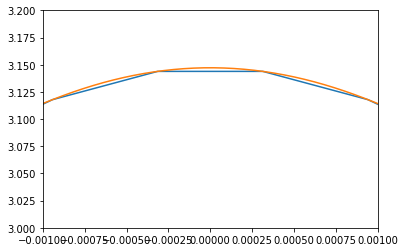

In [83]:
fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.plot(adaptive_kxgrid, fine_integrand)
plt.ylim(3, 3.2)
plt.xlim([-0.001, 0.001])
plt.show()

In [15]:
print(peakvals)

[-0.03927383555342745, -0.0028277161598464495, 0.0028277161598468936, 0.039273835553427894]


In [23]:
print(call_int(0.0007858974537667202), call_int(0.0006657773336470434), call_int(0.0006557773336470434))

-0.02768159845402769 0.35467820799163746 0.3548090193087231


In [24]:
omega_test = 0.002
RECURSIONS = 22
delta = 1e-6 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
print(call_int(0.0007858974537667202), call_int(0.0006657773336470434), call_int(0.0006557773336470434))

0.0011841572685279708 0.3546681771813024 0.354434067097248


In [25]:
omega_test = 0.002
RECURSIONS = 15
delta = 1e-6 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
print(call_int(0.0007858974537667202), call_int(0.0006657773336470434), call_int(0.0006557773336470434))

-0.07075707893660069 0.33081963921513957 0.4220617536610272


In [26]:
omega_test = 0.002
RECURSIONS = 25
delta = 1e-6 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
print(call_int(0.0007858974537667202), call_int(0.0006657773336470434), call_int(0.0006557773336470434))

0.001215144647411729 0.35466817718130067 0.3544340671520597


In [56]:
omega_test = 0.002
RECURSIONS = 30
delta = 1e-5 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
print(call_int(0.0007858974537667202), call_int(0.0006657773336470434), call_int(0.0006557773336470434))

2 tnb 2.318709396863067 (5, 3)
3 tnb 47.91702225720119 (4, 2)
4 tnb 20.59611427340803 (1, 3)
5 tnb 16.274390397966226 (5, 3)
6 tnb 1.9573927625305996 (1, 2)
7 tnb 5.492974410680443 (1, 3)
8 tnb 36.10553276445248 (4, 3)
9 tnb 8.760409739458243 (0, 3)
10 tnb 4.234494307274258 (1, 3)
11 tnb 2.7884007618771736 (0, 2)
12 tnb 8.147907344081853 (4, 3)
13 tnb 3.0913977647795825 (1, 3)
14 tnb 1.5290801081754541 (1, 3)
15 tnb 1.1392864218205423 (0, 3)
16 tnb 0.4400122771602616 (4, 3)
17 tnb 0.08622058020669654 (4, 3)
18 tnb 0.003680979261626506 (0, 3)
19 tnb 6.688485074596507e-06 (0, 3)
20 tnb 2.2083955700525045e-11 (0, 3)
21 tnb 2.4075486804681996e-22 (0, 3)
22 tnb 2.861353382399264e-44 (0, 3)
23 tnb 4.041702446849376e-88 (0, 3)
24 tnb 8.063990681584118e-176 (0, 3)
25 tnb 0.0 (0, 0)
26 tnb 0.0 (0, 0)
27 tnb 0.0 (0, 0)
28 tnb 0.0 (0, 0)
29 tnb 0.0 (0, 0)
2 tnb 1.551182880853221 (1, 6)
3 tnb 48.03386256774337 (4, 6)
4 tnb 18.951343317641374 (5, 7)
5 tnb 17.948410423852888 (1, 7)
6 tnb 5.287771208

In [69]:
omega_test = 0.002
RECURSIONS = 30
delta = 3.0e-6 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
print(call_int(0.0007858974537667202), call_int(0.0006657773336470434), call_int(0.0006557773336470434))

2 tnb 2.3187136256613927 (5, 3)
3 tnb 47.91762912993207 (4, 2)
4 tnb 20.596085290437422 (1, 3)
5 tnb 16.27542343885424 (5, 3)
6 tnb 1.9573905919020178 (1, 2)
7 tnb 5.505081348511341 (1, 3)
8 tnb 36.91104116893518 (4, 3)
9 tnb 8.555388631964297 (0, 3)
10 tnb 4.2352535324466904 (1, 3)
11 tnb 2.7317360293824353 (5, 3)
12 tnb 12.66591534841162 (4, 3)
13 tnb 9.829029715363774 (1, 3)
14 tnb 4.606990366969213 (5, 3)
15 tnb 3.82518099049273 (5, 3)
16 tnb 1.7668725485855061 (1, 3)
17 tnb 1.3402025095126195 (0, 2)
18 tnb 0.7384312528463979 (4, 3)
19 tnb 0.2780752087075541 (0, 3)
20 tnb 0.03809639866554461 (0, 3)
21 tnb 0.0007169928779293884 (0, 3)
22 tnb 2.5396456973414234e-07 (0, 3)
23 tnb 3.1863223909173486e-14 (0, 3)
24 tnb 5.015599845734121e-28 (0, 3)
25 tnb 1.242765562151844e-55 (0, 3)
26 tnb 7.629953123970282e-111 (0, 3)
27 tnb 2.8759887908482566e-221 (0, 3)
28 tnb 0.0 (0, 0)
29 tnb 0.0 (0, 0)
2 tnb 1.551181679041429 (1, 6)
3 tnb 48.03295867288634 (4, 6)
4 tnb 18.95180174016818 (5, 7)
5 tn

new_peakvals= [-0.04291491399572926, -0.010419122308012407, -0.007380450050483751, -0.00523830790834161, 5.734514152803526e-06, 0.0052339371228267775, 0.007376079264968919, 0.010419122308011963, 0.04291491399572881]
ranges= [(-3.141592653589793, -0.04291541399572926), (-0.04291441399572926, -0.010419622308012407), (-0.010418622308012406, -0.007380950050483751), (-0.007379950050483751, -0.005238807908341609), (-0.00523780790834161, 5.234514152803526e-06), (6.234514152803527e-06, 0.005233437122826778), (0.005234437122826777, 0.007375579264968919), (0.007376579264968919, 0.010418622308011962), (0.010419622308011963, 0.04291441399572881), (0.04291541399572881, 3.141592653589793)]


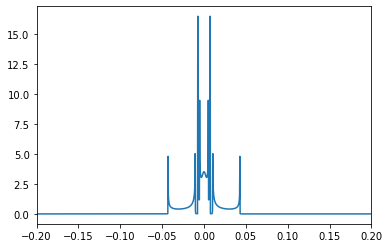

In [84]:
omega_test = 0.00004
RECURSIONS = 30
delta = 1e-6 #if omega>1e-3 else 1e-6
num_pp = 1000
call_int = lambda kx : MOMfastrecDOSfull(omega_test,ret_H0(float(kx)),ret_Ty(float(kx)),RECURSIONS,delta)[1,1]
    
kxgrid = np.linspace(-np.pi,np.pi,20000,dtype=np.double)
# sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
# 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
peakvals = [kxgrid[peak] for peak in peaks] #peakvals
peakvals = sorted(peakvals)

adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
new_peakvals = sorted(new_peakvals)

print('new_peakvals=', new_peakvals)



start,stop = -np.pi,np.pi
ranges = []
# eta = 0.5*delta
eta = 0.5*delta
current = start
for peak in new_peakvals:
    ranges += [(current, peak-eta)]
    current = peak+eta
ranges += [(current, stop)]  
print('ranges=', ranges)
#intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
#LDOS = np.sum(intlist)
#print('done mpmath', omega)

fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.xlim([-0.2, 0.2])
plt.show()

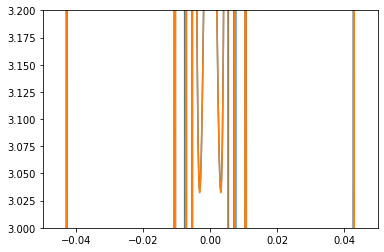

In [85]:
fig = plt.subplot(111)
plt.plot(kxgrid, sparseLDOS)
plt.plot(adaptive_kxgrid, fine_integrand)
plt.ylim(3, 3.2)
plt.xlim([-0.05, 0.05])
plt.show()

### Section for running scripts

In [8]:
!python run_integration_7e6.py

1.3560151105656348e-06 0.1053712800320647
1.3940828262825785e-06 0.10532858721338977
1.4332192255035739e-06 0.10528467147646733
1.4734543096198343e-06 0.10523968335865903
1.5148189222583473e-06 0.10519354214151268
1.5573447729261351e-06 0.1051462234605389
1.6010644613183177e-06 0.10509770240969439
1.6460115023085498e-06 0.10504792589702731
1.6922203516410355e-06 0.10499690001560254
1.7397264323438024e-06 0.10494459803519555
1.7885661618834618e-06 0.10489099622505718
0.00044186599563859414 0.09849402476078618
0.0004542705986374043 0.09989365338067936
0.0004670234388327335 0.10139060051622195
0.000480134292365345 0.10298758192101105
0.0004936132098237916 0.10468346242268017
0.0005074705239490466 0.10646861068365493
0.000521716857555435 0.10832047688670474
0.000536363131673924 0.11020765376667034
0.0005514205739240302 0.11207708300639924
0.0005669007271207433 0.11387113675435231
0.0005828154581230846 0.11551756632528197
0.03140465219496749 0.022612003074795946
0.03228628202536733 0.022591

 2.70935387e-06 2.78541416e-06 2.86360972e-06 2.94400048e-06
 3.02664806e-06 3.11161583e-06 3.19896892e-06 3.28877429e-06
 3.38110078e-06 3.47601918e-06 3.57360225e-06 3.67392478e-06
 3.77706369e-06 3.88309805e-06 3.99210913e-06 4.10418050e-06
 4.21939808e-06 4.33785019e-06 4.45962763e-06 4.58482375e-06
 4.71353453e-06 4.84585864e-06 4.98189752e-06 5.12175544e-06
 5.26553963e-06 5.41336030e-06 5.56533078e-06 5.72156756e-06
 5.88219040e-06 6.04732245e-06 6.21709029e-06 6.39162405e-06
 6.57105755e-06 6.75552832e-06 6.94517777e-06 7.14015130e-06
 7.34059837e-06 7.54667263e-06 7.75853206e-06 7.97633907e-06
 8.20026062e-06 8.43046837e-06 8.66713880e-06 8.91045332e-06
 9.16059848e-06 9.41776601e-06 9.68215306e-06 9.95396231e-06
 1.02334021e-05 1.05206867e-05 1.08160363e-05 1.11196773e-05
 1.14318425e-05 1.17527712e-05 1.20827094e-05 1.24219100e-05
 1.27706330e-05 1.31291459e-05 1.34977233e-05 1.38766479e-05
 1.42662102e-05 1.46667087e-05 1.50784505e-05 1.55017512e-05
 1.59369353e-05 1.638433

In [9]:
#this is for delta'=gamma4=0
!python run_integration_7e6.py

2.1667412433870192e-05 0.13633080544213202
2.2229964825261955e-05 0.13660126908363984
2.280712279976275e-05 0.13688194727522443
2.3399265563045188e-05 0.13717325191454663
2.400678216612259e-05 0.13747543983158952
2.463007176096422e-05 0.13778870475792696
2.526954386274699e-05 0.13811414483224585
2.592561861891612e-05 0.13845196840355806
2.6598727085231356e-05 0.13880258893991534
2.728931150898024e-05 0.13916643685264274
2.7997825619544458e-05 0.1395446238314482
2.8724734926510143e-05 0.13993735825182033
0.000638549847031294 0.0808607345574992
0.0006551285568595509 0.08019014367968395
0.0006721377007734901 0.07952610124269464
0.0006895884541603425 0.0788725446522355
0.0007074922825546201 0.07822621275270217
0.0007258609491712285 0.07758960147250664
0.0007447065226341616 0.0769592897244483
0.0007640413849058565 0.07633795808189285
0.00078387823942242 0.07572438962001506
0.0008042301194400692 0.07511798129960494
0.0008251103965982717 0.07451955020264629
0.0008465327897052115 0.07392783246

0.5837592378488591 0.06688360458927475
0.5989154156458704 0.06870805503177532
0.6144650942399928 0.07056988550498978
0.630418490117164 0.07250814291594566
0.646786085014588 0.07450936126285229
0.663578632807471 0.07654545201216045
0.6808071665745572 0.07864684719258967
0.6984830058471084 0.08079897298487847
0.7166177640460879 0.08300463293422064
0.7352233561124377 0.08528759502074183
1.1712393100071887e-05 0.1321444347381369
1.201648269856341e-05 0.13233836246137412
1.2328467394420658e-05 0.13240248581028874
1.2648552168552958e-05 0.13252153358971025
1.2976947323801866e-05 0.13255698643083252
1.3313868623114841e-05 0.13268759342799163
1.3659537431306314e-05 0.13282289514106085
1.4014180860499308e-05 0.13296342722390206
1.437803191934318e-05 0.13310912967131214
1.4751329666105498e-05 0.13326024616124527
1.5134319365738664e-05 0.13341711946668672
1.5527252651024463e-05 0.13357959317408907
0.000868511373751352 0.0733432041782299
0.00089106058915702 0.07276556003809587
0.000914195251260080